# EDA notebook

In [2]:
import os

os.getcwd()

'/Users/maxmartyshov/Desktop/IU/year3/sem2/XAI/Credit-Risk-Analysis-Counterfactual-Explanations/notebooks'

In [3]:
import pandas as pd

df = pd.read_csv('../data/raw/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Note for data cleaning: max age of 144 and max person employment length in years is 123

In [ ]:
foos = df[df['person_age'] < df['person_emp_length']]
print(f'number of people with unrealistic empoloyment length {foos.shape[0]}')

number of people with unrealistic empoloyment length 2


In [ ]:
foos = df[df['person_age'] - df['person_emp_length'] < 14]
print(f'number of people with unrealistic empoloyment length and who started officially working befor 14 y.o.: {foos.shape[0]}')

number of people with unrealistic empoloyment length and who started officially working befor 14 y.o.: 2


Note: mean for `loan_status` is *0.21*, so data is imbalanced towards `did not default`

In [5]:
df_for_pie = df[['loan_intent', 'loan_grade', 'loan_status', 'person_home_ownership']]
df_for_pie['loan_grade'] = df_for_pie['loan_grade'].replace({'E': 'Other', 'F': 'Other', 'G': 'Other'})

/var/folders/fw/0f9ty9l93rj6hg9ppkj65vp00000gn/T/ipykernel_95431/2871825020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_pie['loan_grade'] = df_for_pie['loan_grade'].replace({'E': 'Other', 'F': 'Other', 'G': 'Other'})


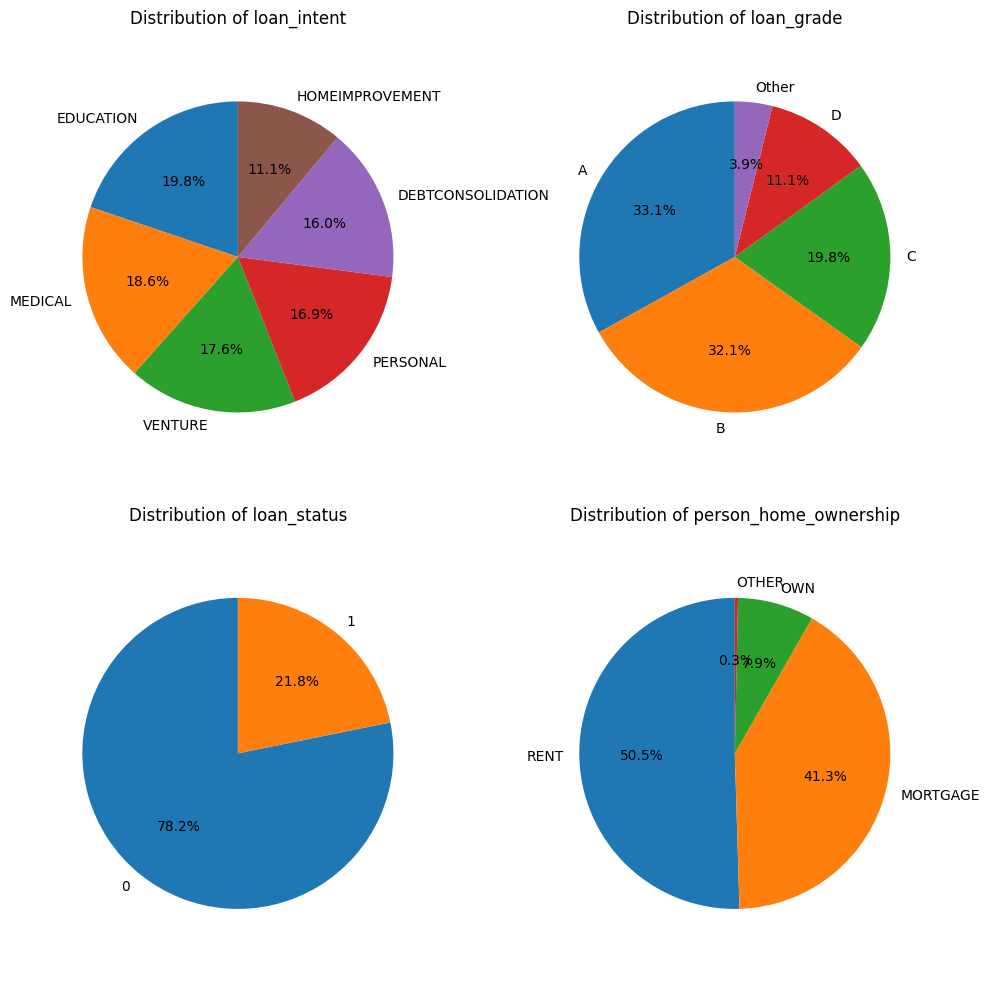

In [7]:
import matplotlib.pyplot as plt

# Columns you want to visualize
columns = df_for_pie.columns.values


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))  # 3 charts side-by-side

for col, ax in zip(columns, axes.flatten()):
    counts = df_for_pie[col].value_counts()
    
    counts.plot(
        kind='pie',
        ax=ax,
        autopct='%1.1f%%',
        startangle=90,
        shadow=False
    )
    
    ax.set_ylabel('')            # Remove default y-axis label
    ax.axis('equal')             # Ensure the pie is circular
    ax.set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


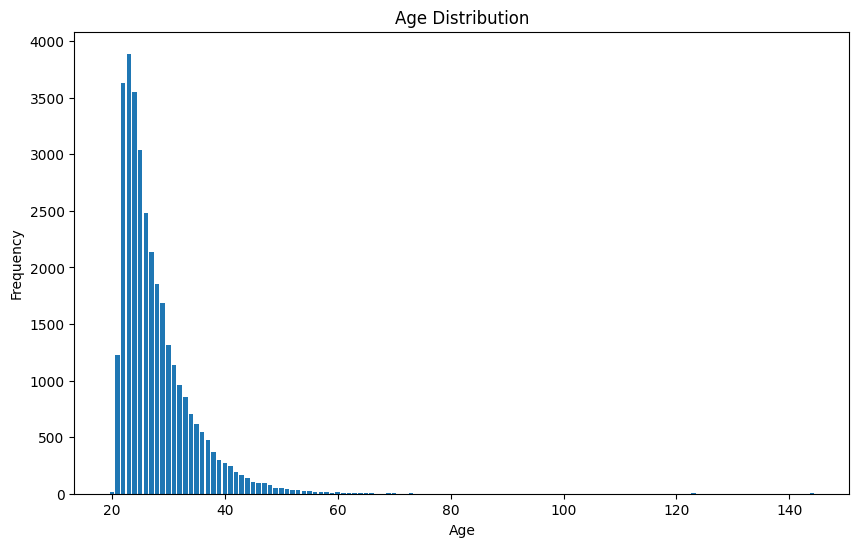

In [8]:
plt.figure(figsize=(10, 6))
age_frequencies = df['person_age'].value_counts()
plt.bar(age_frequencies.index, age_frequencies.values)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


We see that the distribution has a huge tail, which affects the analysis. So we either cut the tails (remove all ages, where count(age) < 5), or we do the log scale on the counts to make the distribution more linear like

Lets first try the log scale, but we also would like to remove the age like 130 and 144:

In [9]:
df_cut = df[df['person_age'] <= 70]

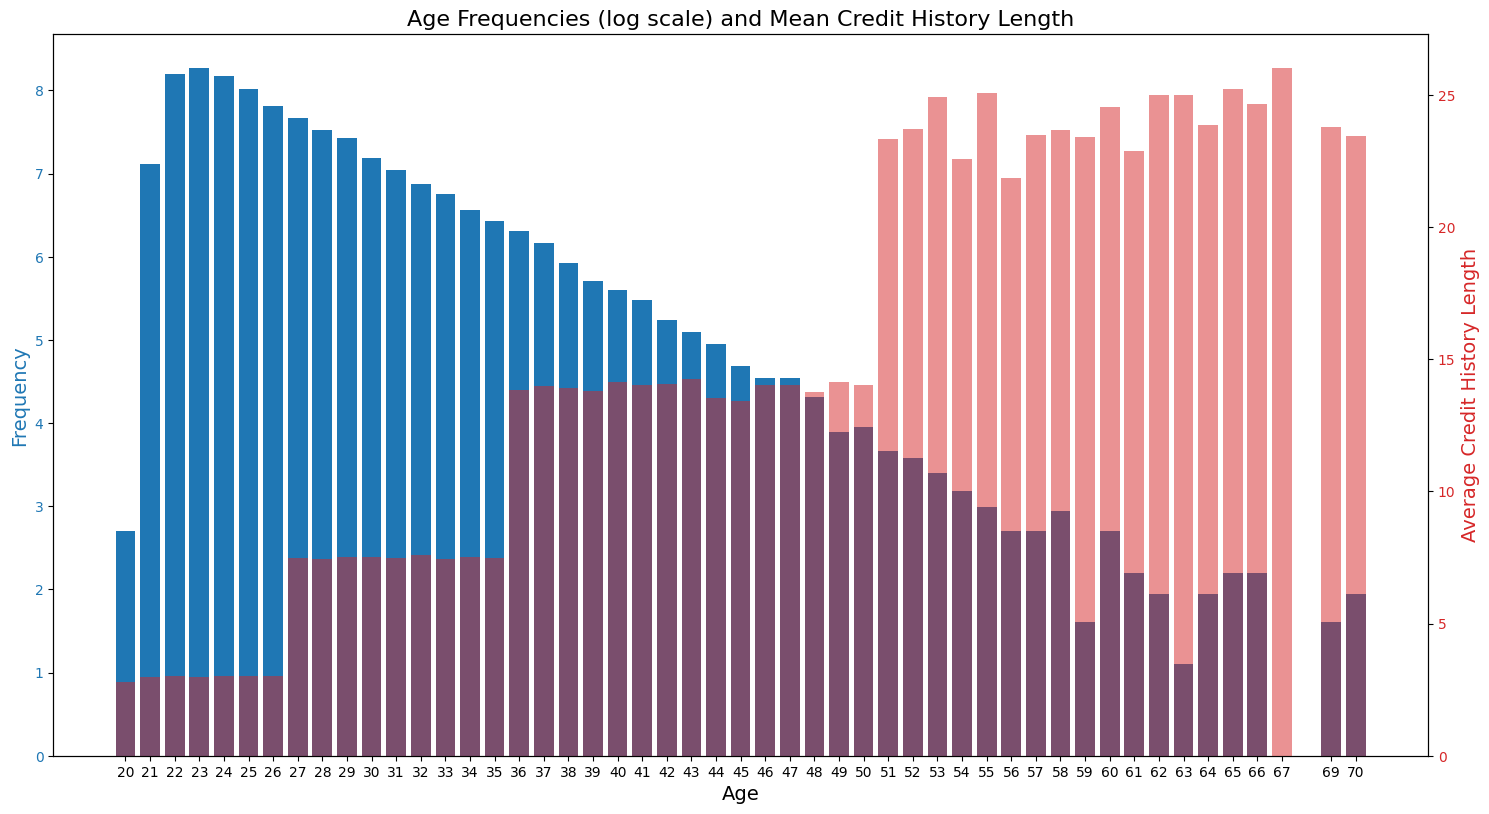

In [10]:
import numpy as np


age_frequencies = df_cut['person_age'].value_counts()
mean_credit_history = df_cut['cb_person_cred_hist_length'].groupby(df_cut['person_age']).mean()

fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Age', fontsize=14)
ax1.set_ylabel('Frequency', color=color, fontsize=14)
ax1.bar(age_frequencies.index, np.log(age_frequencies.values), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(age_frequencies.index)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Credit History Length', color=color, fontsize=14)
ax2.bar(mean_credit_history.index, mean_credit_history.values, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Age Frequencies (log scale) and Mean Credit History Length', fontsize=16)
plt.show()

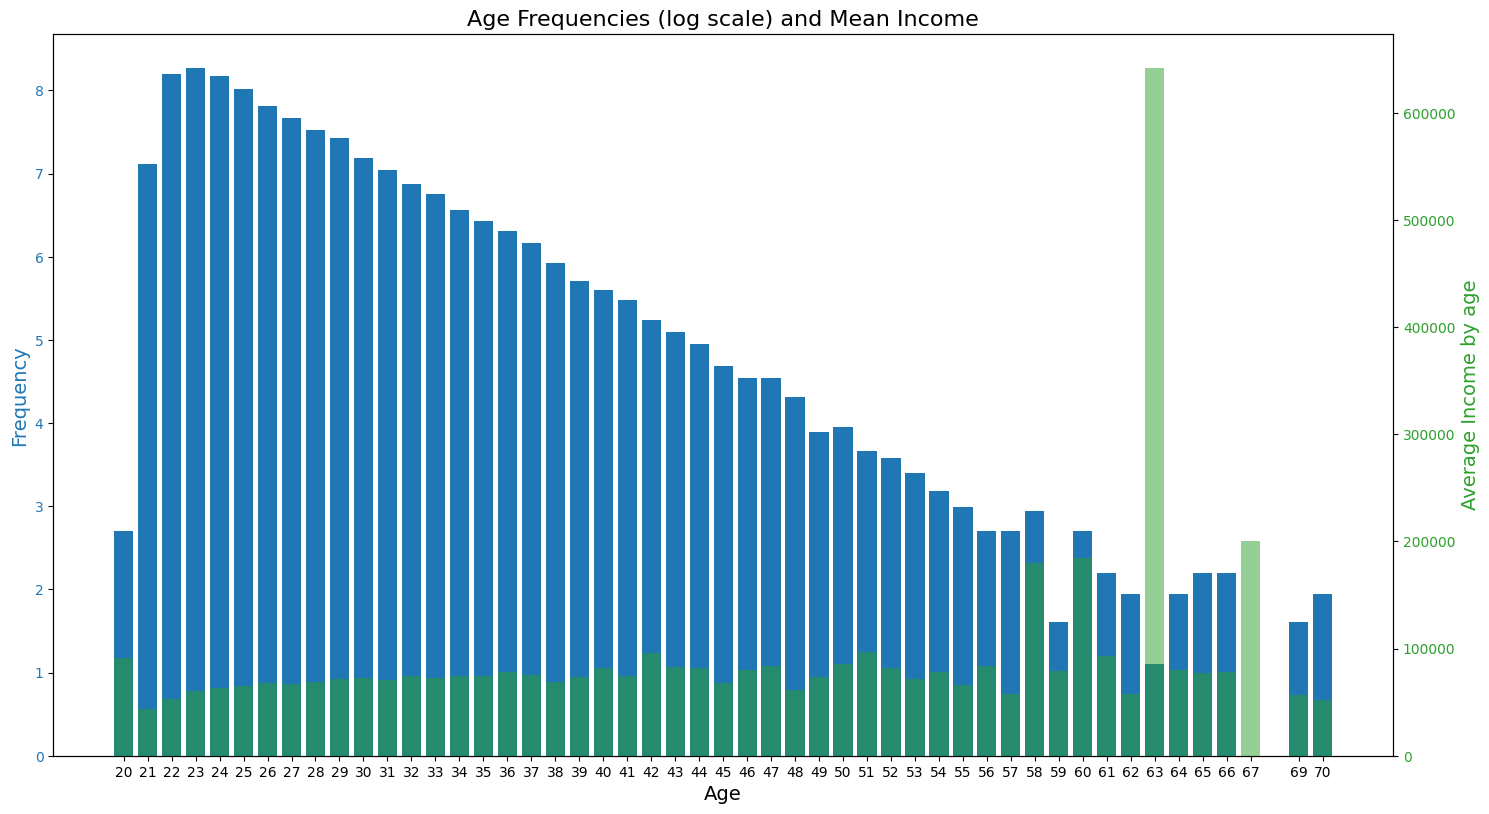

In [11]:
age_frequencies = df_cut['person_age'].value_counts()
mean_income = df_cut['person_income'].groupby(df_cut['person_age']).mean()

fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Age', fontsize=14)
ax1.set_ylabel('Frequency', color=color, fontsize=14)
ax1.bar(age_frequencies.index, np.log(age_frequencies.values), color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(age_frequencies.index)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Average Income by age', color=color, fontsize=14)
ax2.bar(mean_income.index, mean_income.values, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Age Frequencies (log scale) and Mean Income', fontsize=16)
plt.show()

Now lets cut the tails and see the difference

In [12]:
df[df['person_age'] == 58].count()

person_age                    19
person_income                 19
person_home_ownership         19
person_emp_length             19
loan_intent                   19
loan_grade                    19
loan_amnt                     19
loan_int_rate                 17
loan_status                   19
loan_percent_income           19
cb_person_default_on_file     19
cb_person_cred_hist_length    19
dtype: int64

In [13]:
age_counts = df['person_age'].value_counts()
df_no_tails = df[df['person_age'].isin(age_counts[age_counts >= 20].index)]

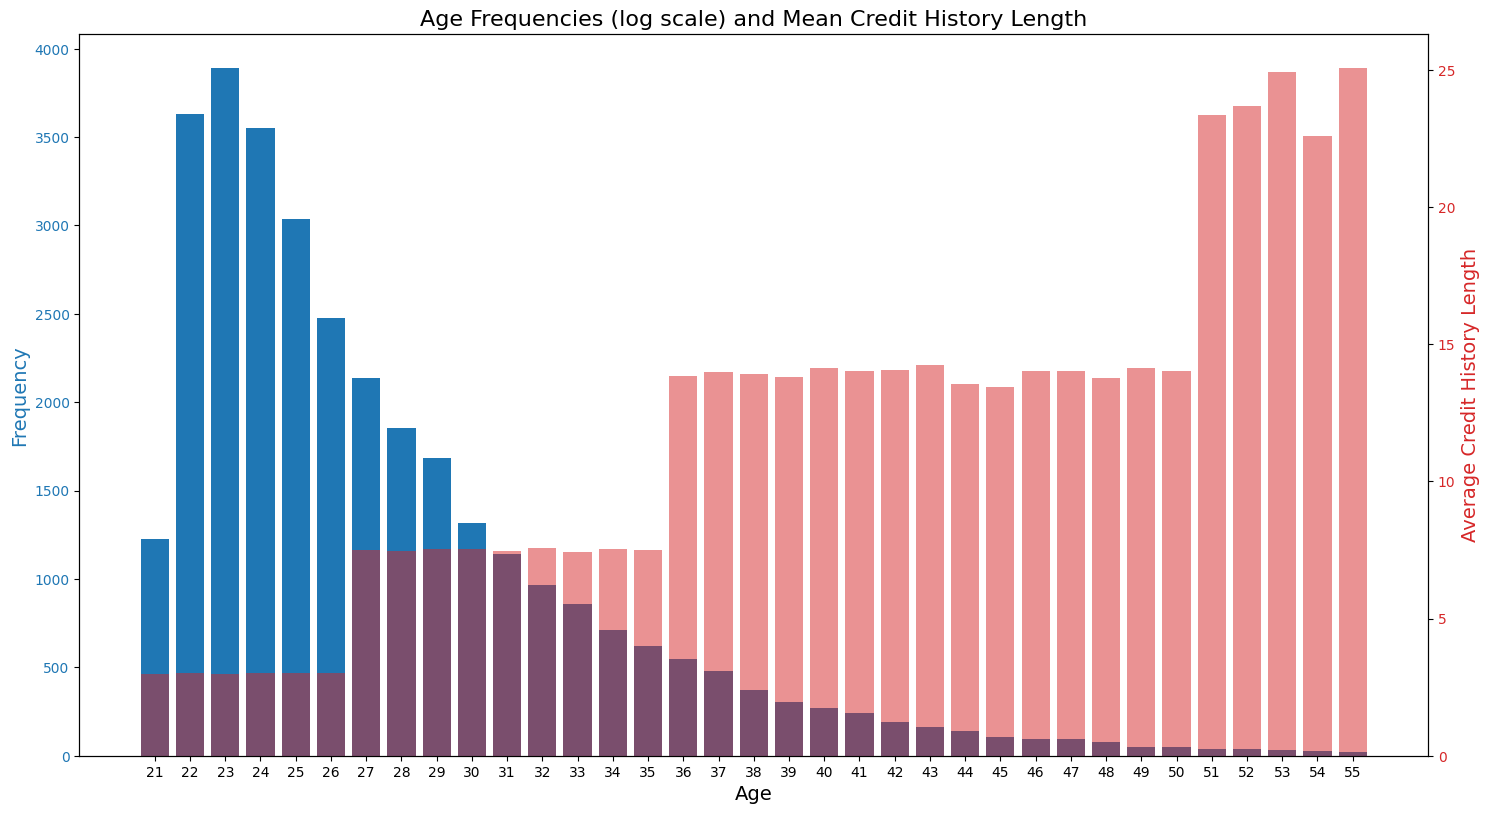

In [14]:
age_frequencies = df_no_tails['person_age'].value_counts()
mean_credit_history = df_no_tails['cb_person_cred_hist_length'].groupby(df_no_tails['person_age']).mean()

fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Age', fontsize=14)
ax1.set_ylabel('Frequency', color=color, fontsize=14)
ax1.bar(age_frequencies.index, age_frequencies.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(age_frequencies.index)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Credit History Length', color=color, fontsize=14)
ax2.bar(mean_credit_history.index, mean_credit_history.values, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Age Frequencies (log scale) and Mean Credit History Length', fontsize=16)
plt.show()

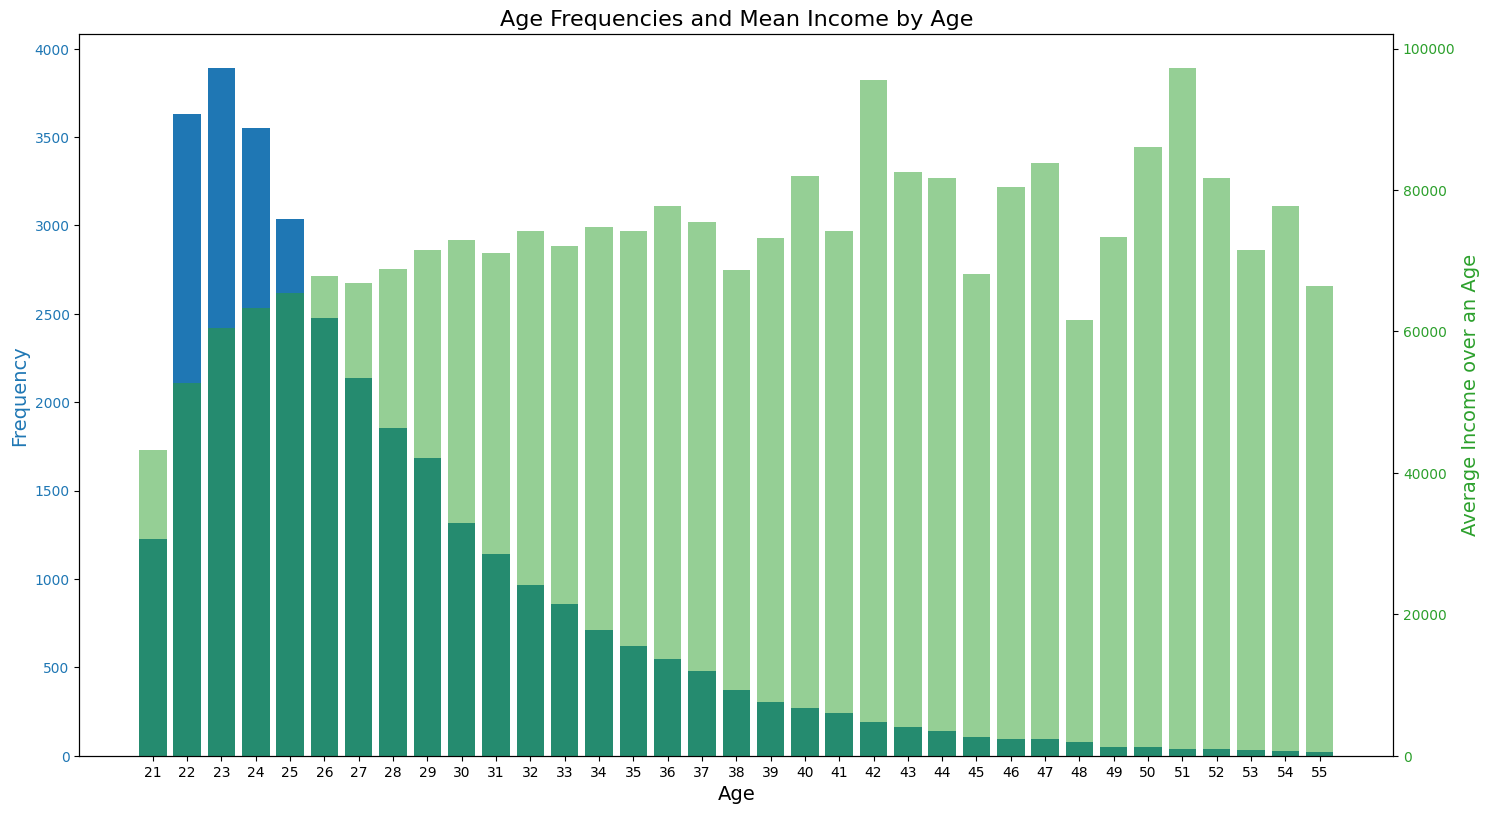

In [15]:
age_frequencies = df_no_tails['person_age'].value_counts()
mean_income = df_no_tails['person_income'].groupby(df_no_tails['person_age']).mean()

fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:blue'
ax1.set_xlabel('Age', fontsize=14)
ax1.set_ylabel('Frequency', color=color, fontsize=14)
ax1.bar(age_frequencies.index, age_frequencies.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(age_frequencies.index)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Average Income over an Age', color=color, fontsize=14)
ax2.bar(mean_income.index, mean_income.values, color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Age Frequencies and Mean Income by Age', fontsize=16)
plt.show()

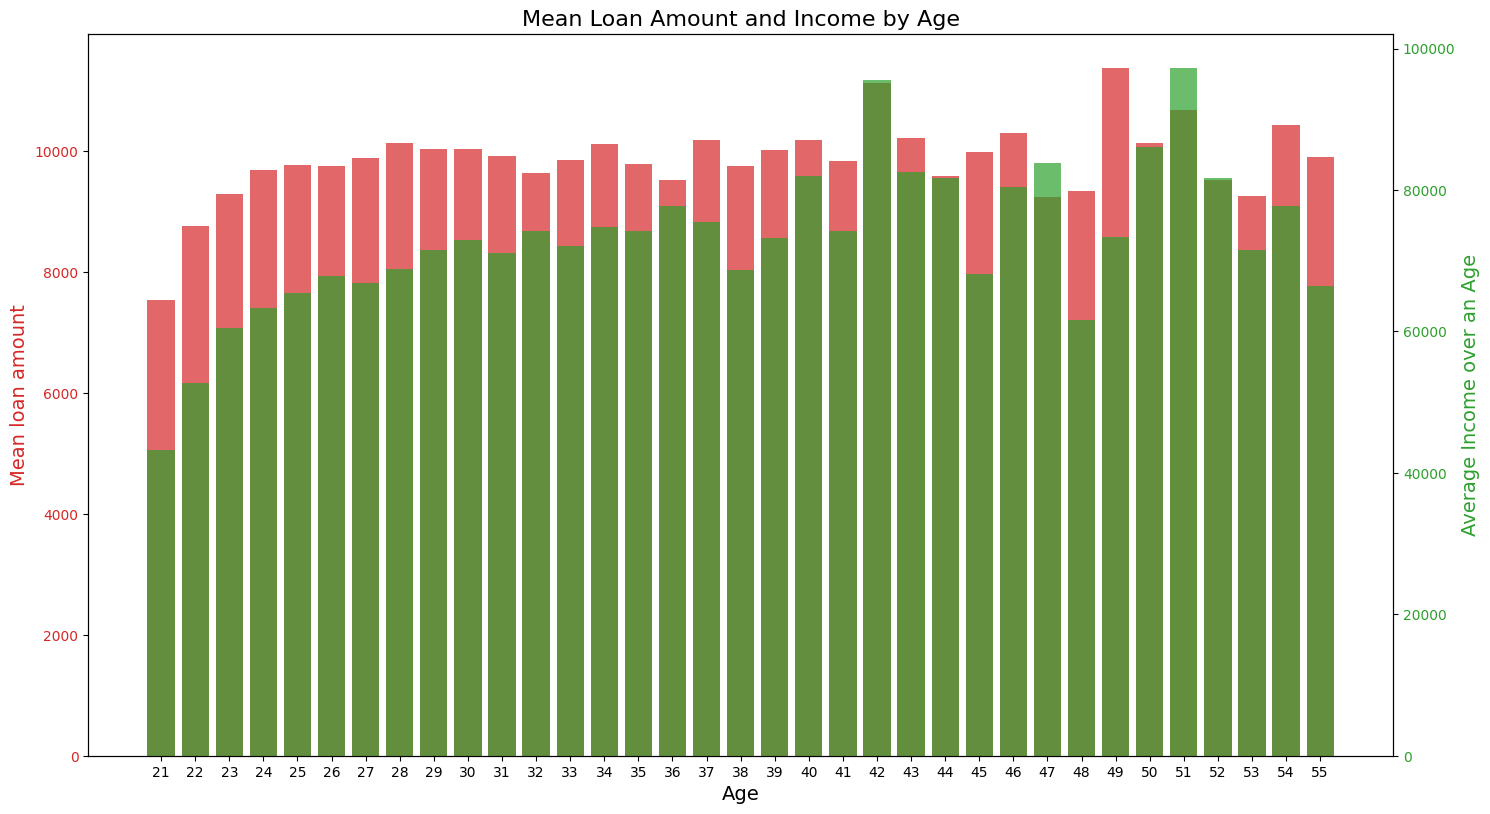

In [16]:
age_frequencies = df_no_tails['person_age'].value_counts()
mean_income = df_no_tails['person_income'].groupby(df_no_tails['person_age']).mean()
mean_loan_amount = df_no_tails['loan_amnt'].groupby(df_no_tails['person_age']).mean()


fig, ax1 = plt.subplots(figsize=(15, 8))

color = 'tab:red'
ax1.set_xlabel('Age', fontsize=14)
ax1.set_ylabel('Mean loan amount', color=color, fontsize=14)
ax1.bar(mean_loan_amount.index, mean_loan_amount.values, color=color, alpha=0.7)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(mean_loan_amount.index)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Average Income over an Age', color=color, fontsize=14)
ax2.bar(mean_income.index, mean_income.values, color=color, alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Mean Loan Amount and Income by Age', fontsize=16)
plt.show()

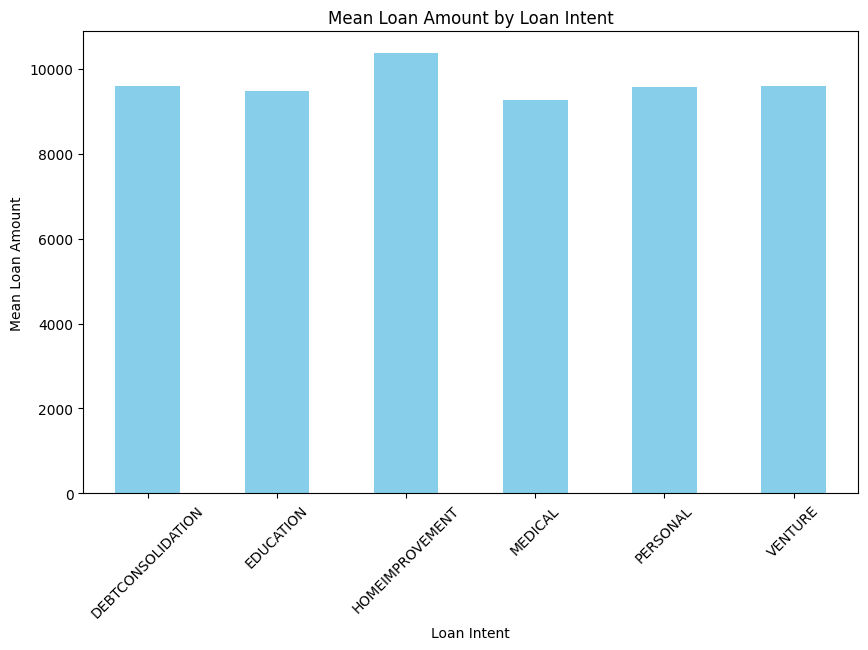

In [17]:
mean_loan_amount_by_intent = df.groupby('loan_intent')['loan_amnt'].mean()

plt.figure(figsize=(10, 6))
mean_loan_amount_by_intent.plot(kind='bar', color='skyblue')
plt.xlabel('Loan Intent')
plt.ylabel('Mean Loan Amount')
plt.title('Mean Loan Amount by Loan Intent')
plt.xticks(rotation=45)
plt.show()

/var/folders/fw/0f9ty9l93rj6hg9ppkj65vp00000gn/T/ipykernel_95431/1693505132.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nondefault_data, default_data], labels=['Non-Default', 'Default'])


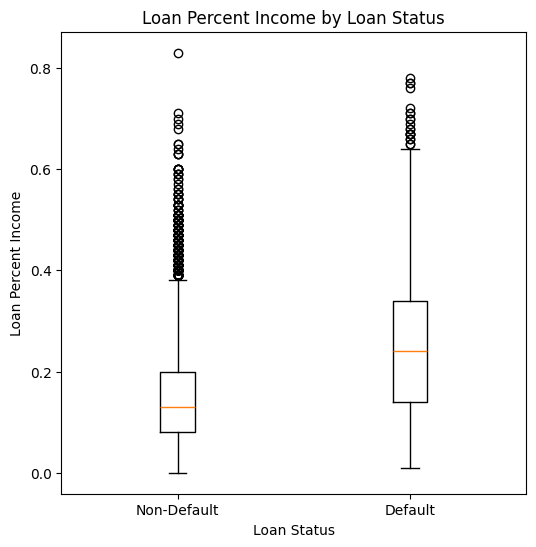

In [19]:

# Separate the data by loan_status
default_data = df[df['loan_status'] == 1]['loan_percent_income']
nondefault_data = df[df['loan_status'] == 0]['loan_percent_income']

# Create a figure
plt.figure(figsize=(6, 6))

# Boxplot, two groups side by side
plt.boxplot([nondefault_data, default_data], labels=['Non-Default', 'Default'])

# Label axes and title
plt.xlabel('Loan Status')
plt.ylabel('Loan Percent Income')
plt.title('Loan Percent Income by Loan Status')

# Display the chart
plt.show()


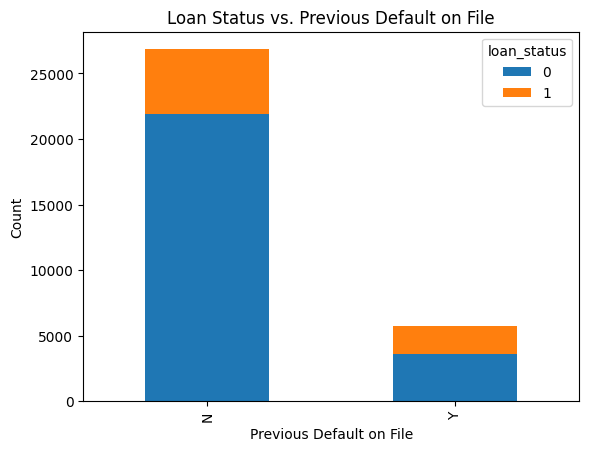

In [25]:
cross_tab = pd.crosstab(df['cb_person_default_on_file'], df['loan_status'])
cross_tab.plot(kind='bar', stacked=True)
plt.xlabel('Previous Default on File')
plt.ylabel('Count')
plt.title('Loan Status vs. Previous Default on File')
plt.show()


In [ ]:
from scipy.stats import chi2_contingency

chi2, p_value, dof, expected = chi2_contingency(cross_tab)
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"significance test passed?: {p_value < 0.05}")

Chi-square statistic: 1044.4395947711112
p-value: 3.934660154785391e-229
significance test passed: True


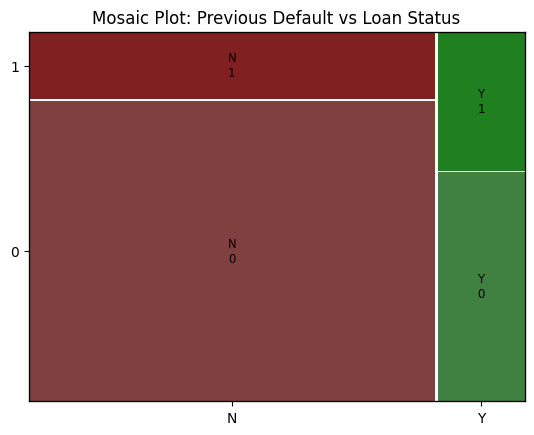

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

crosstab = pd.crosstab(df['cb_person_default_on_file'], df['loan_status'])
data_dict = {}
for row_cat in crosstab.index:
    for col_cat in crosstab.columns:
        data_dict[(row_cat, col_cat)] = crosstab.loc[row_cat, col_cat]

mosaic(data_dict, title='Mosaic Plot: Previous Default vs Loan Status')
plt.show()
